In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import matplotlib.image as mpimg
from google.colab import drive # Модуль для работы с Google Disk
from PIL import Image

In [13]:
# Подключаем гугл диск
drive.mount('/content/drive')
from zipfile import ZipFile
data_path = 'drive/MyDrive/Colab_Notebooks/zipF/kagglecatsanddogs_5340.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall('temp')

# # Разархивируем датасета во временную папку 'temp'
# !unzip -qo 'cat-and-dog.zip' -d ./temp

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './temp/PetImages/'

# Папка в которой будем создавать выборки
BASE_DIR = './dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
os.listdir(IMAGE_PATH)
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Cat', 'Dog']


In [15]:
data_files = []  # Cписок путей к файлам изображений
data_labels = [] # Список меток классов

for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Полный путь к папке с изображениями класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(class_path)

    # Вывод информации о численности класса
    print(f'Размер класса {class_name} составляет {len(class_files)} животных')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса Cat составляет 12501 животных
Размер класса Dog составляет 12501 животных
Общий размер базы для обучения: 25002


In [16]:
# Набор утилит для работы с файловой системой
import shutil

# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

# Создаем папку по пути BASE_DIR
os.mkdir(BASE_DIR)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'train'
train_dir = os.path.join(BASE_DIR, 'train')

# Создаем подпапку, используя путь
os.mkdir(train_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'validation'
validation_dir = os.path.join(BASE_DIR, 'validation')

# Создаем подпапку, используя путь
os.mkdir(validation_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + 'test'
test_dir = os.path.join(BASE_DIR, 'test')

# Создаем подпапку, используя путь
os.mkdir(test_dir)

In [17]:
# Функция создания подвыборок (папок с файлами)
def create_dataset(
    img_path: str,         # Путь к файлам с изображениями классов
    new_path: str,         # Путь к папке с выборками
    class_name: str,       # Имя класса (оно же и имя папки)
    start_index: int,      # Стартовый индекс изображения, с которого начинаем подвыборку
    end_index: int         # Конечный индекс изображения, до которого создаем подвыборку

):

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)

    # Создаем подпапку, используя путь
    os.mkdir(dst_path)

    # Перебираем элементы, отобранного списка с начального по конечный индекс
    for fname in class_files[start_index : end_index]:
        # Путь к файлу (источник)
        src = os.path.join(src_path, fname)
        # Новый путь расположения файла (назначение)
        dst = os.path.join(dst_path, fname)
        # Копируем файл из источника в новое место (назначение)
        shutil.copyfile(src, dst)

In [18]:
for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен

    # Создаем обучающую выборку для заданного класса из диапазона (0-1000)
    create_dataset(IMAGE_PATH, train_dir, class_name, 0, 1000)
    # Создаем проверочную выборку для заданного класса из диапазона (1000-1500)
    create_dataset(IMAGE_PATH, validation_dir, class_name, 1000, 1500)
    # Создаем тестовую выборку для заданного класса из диапазона (1500-2000)
    create_dataset(IMAGE_PATH, test_dir, class_name, 1500, 2000)



In [19]:
from keras import layers    # Импортируем слои
from keras import models    # Импортируем модели
model = models.Sequential() # Создаем модель как последовательность слоев

# Добавляем слои модели
model.add(layers.Conv2D(32, (3, 3), activation='relu',
 input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
from keras import optimizers

# Оптимизатор можно задавать по имени с параметрами по умолчанию,
# а можно как метод с заданием значений параметров
# Описание параметров RMSprop - https://keras.io/api/optimizers/rmsprop/
model.compile(loss='binary_crossentropy',
 optimizer=optimizers.RMSprop(learning_rate=1e-4),
 metrics=['acc'])

In [21]:
BATCH_SIZE = 20

from tensorflow.keras.preprocessing.image import ImageDataGenerator # Импортируем генератор изображений

# Создаем генераторы для  обучающей и тестовой выборок
# Предварительно нормализуем данные делением на 255, приводим интесивность пикселей картинки к диапазону от 0 до 1
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Генерируем мини-батчи для обучения из заданной директории
train_generator = train_datagen.flow_from_directory(
    train_dir, # Целевой каталог
    target_size=(150, 150), # Привести все изображения к размеру 150 × 150
    batch_size=BATCH_SIZE, # Размер батча
    class_mode='binary'  # Делаем генерацию для задачи бинарной классификации (метки бинарные)
)

# Генерируем мини-батчи для проверки из заданной директории
validation_generator = test_datagen.flow_from_directory(
    validation_dir, # Целевой каталог
    target_size=(150, 150), # Привести все изображения к размеру 150 × 150
    batch_size=BATCH_SIZE, # Размер батча
    class_mode='binary'  # Делаем генерацию для задачи бинарной классификации (метки бинарные)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [22]:
def generator():
    i = 0
    while True:
        i += 1
        yield i


for item in generator():
    if item > 5:
        break
    print(item, end=' ')

1 2 3 4 5 

In [23]:
# Выводим с помощью генератора пакет с изображениями и метками
for data_batch, labels_batch in train_generator:
    print('Форма пакета с изображениями:', data_batch.shape)
    print('Форма пакета с метками:', labels_batch.shape)
    break

Форма пакета с изображениями: (20, 150, 150, 3)
Форма пакета с метками: (20,)


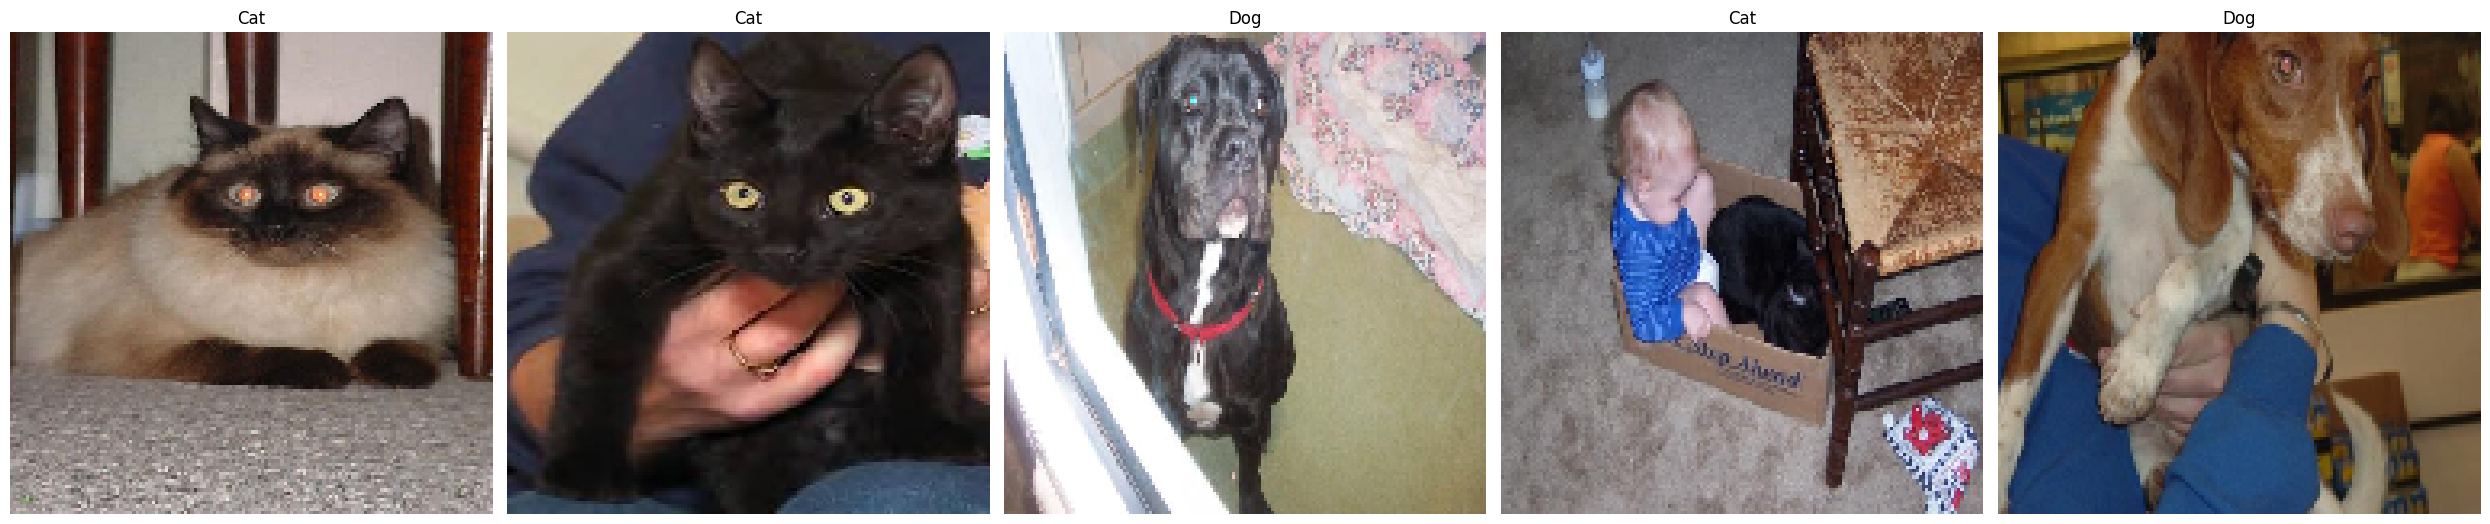

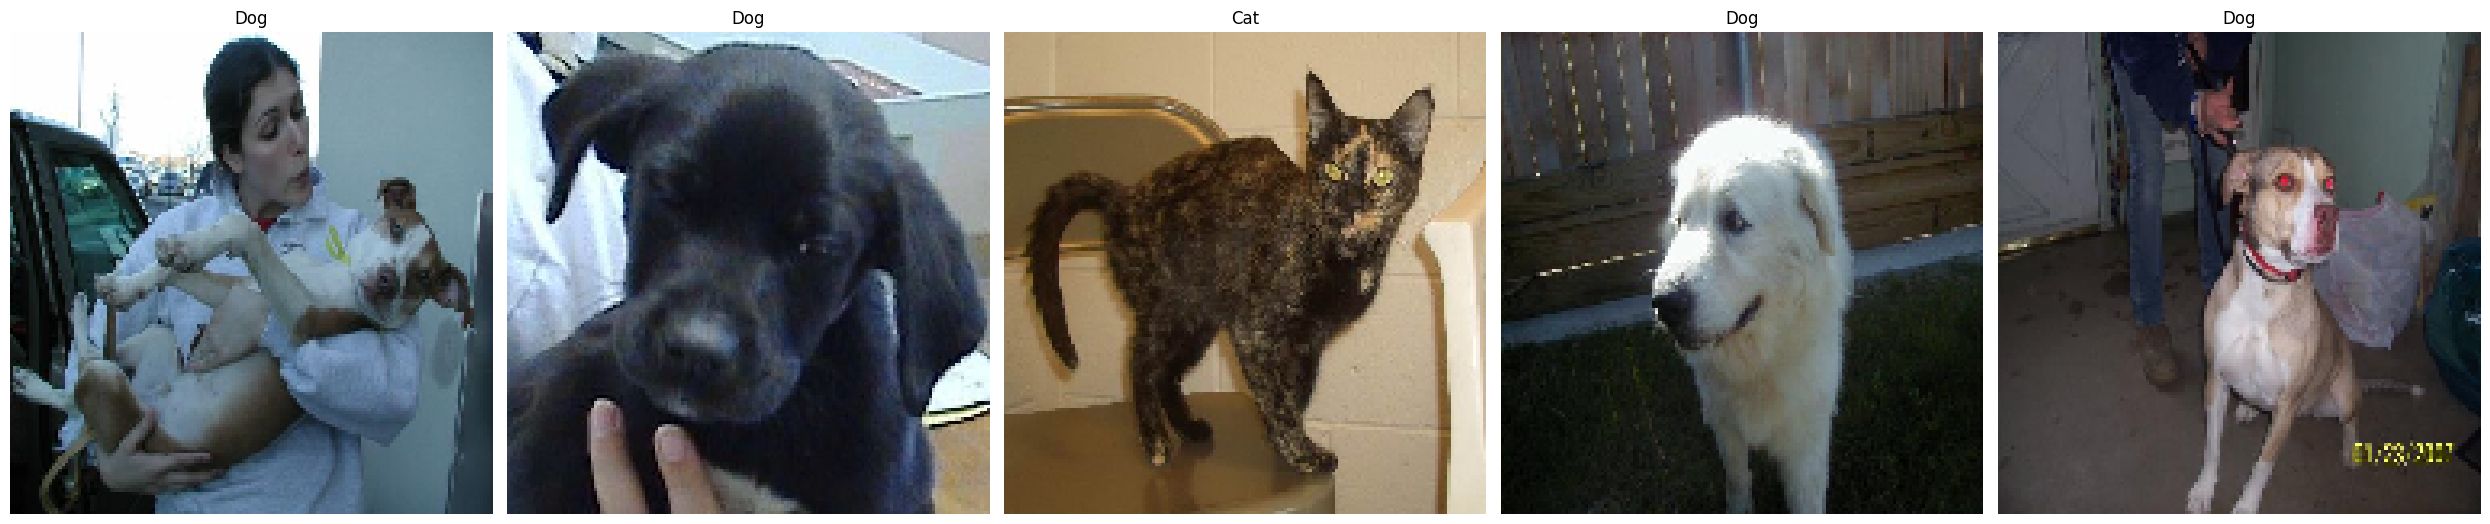

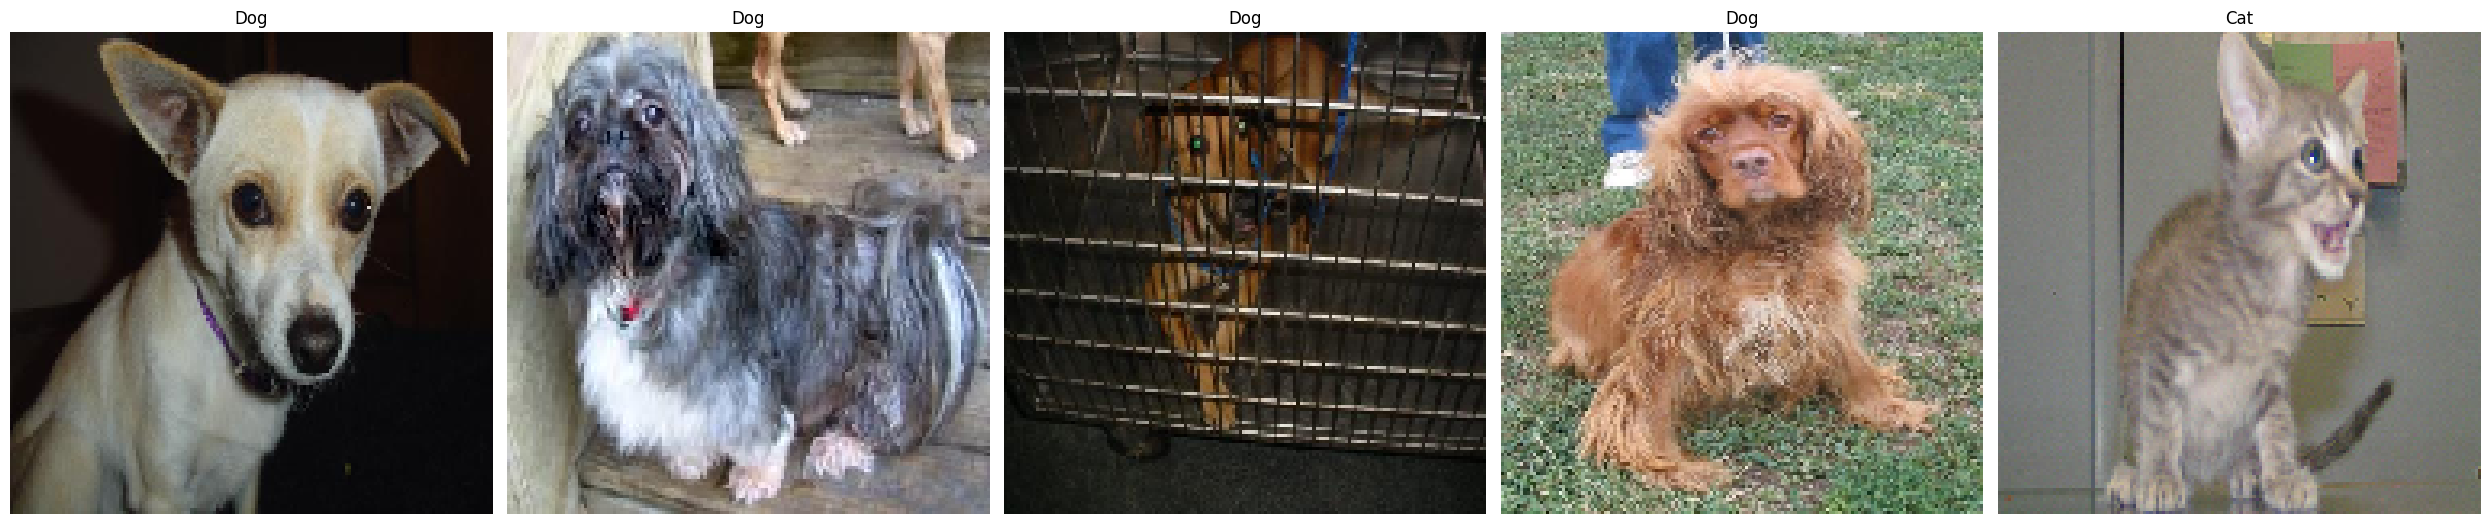

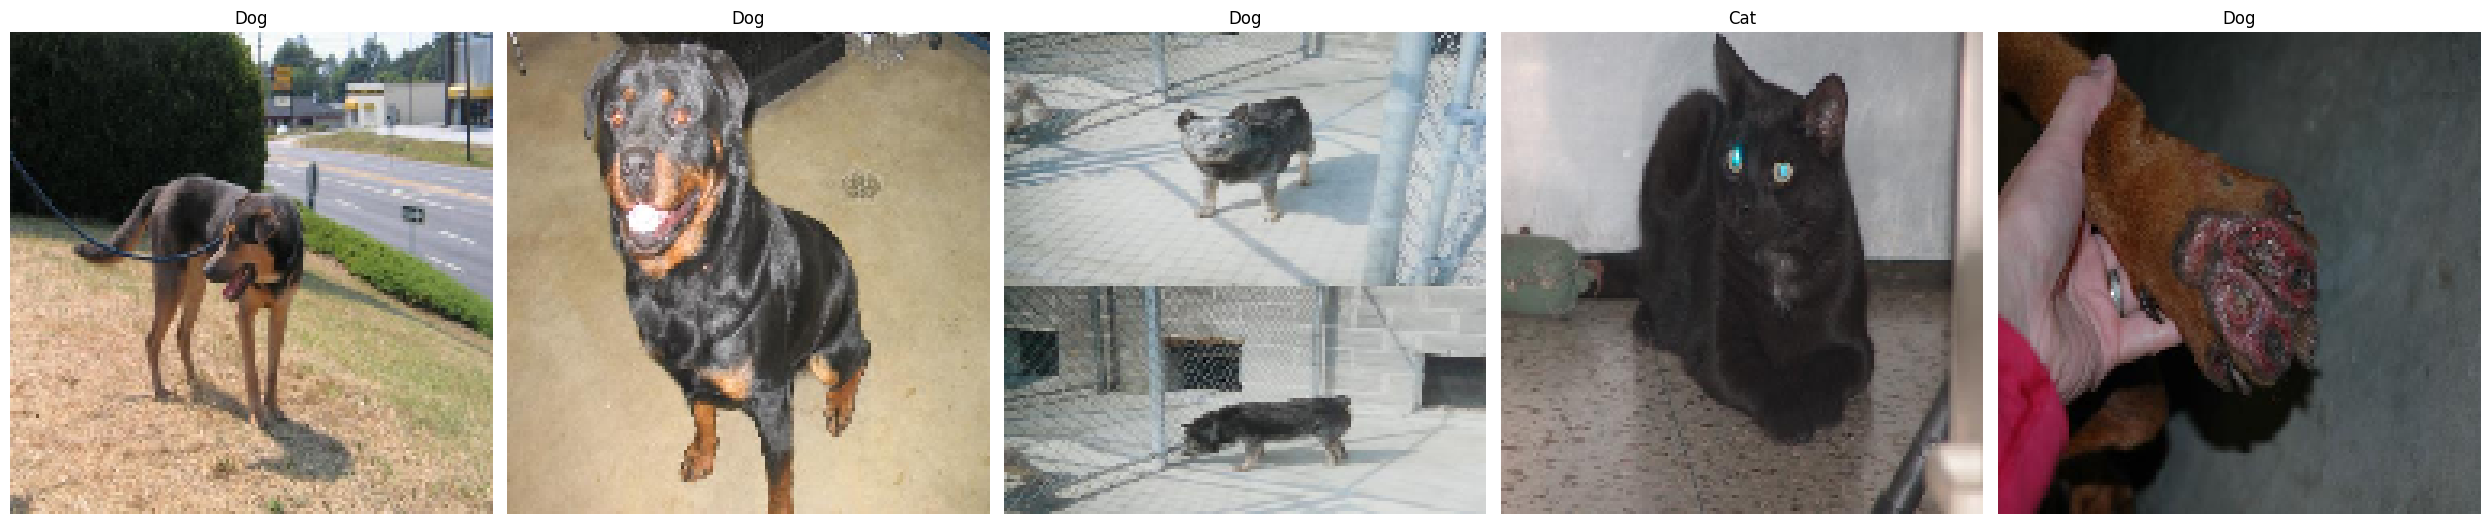

In [24]:
from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt           # Построение графиков
import numpy as np                        # Работа с матрицами
%matplotlib inline


# Функция рисования образцов изображений из заданного батча генератора

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range: # Перебираем диапазон номеров картинок
        ix = i % columns # Отображаем по 5 (или другое число, заданное columns) в строку
        # Остаток от деления на 5 равный нулю говорит, что пора перейти на следующую строку (новый график)
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize) # Область построения графика: одна строка в 5 колонок
        class_label = int(batch[1][i]) # Извлекаем номер класса
        ax[ix].set_title(CLASS_LIST[class_label]) # Отображаем заголовок конкретного рисунка
        ax[ix].imshow(batch[0][i]) # Отображаем изображение животного на графике
        ax[ix].axis('off') # Отключаем отображение осей на графике
        plt.tight_layout() # Автоматически настраивает параметры подзаголовка так, чтобы подзаголовок вписывался в область рисунка

    plt.show() # Отображаем все графики со всеми рисунками
show_batch(validation_generator[0]) # рисуем батч

In [25]:
# цикл обучения
history = model.fit(
    train_generator,                        # генератор для обучения
    epochs=30,                              # число эпох обучения
    validation_data=validation_generator,   # генератор проверочной выборки
)
model.save('cats_and_dogs_small_model.h5') # сохраняем модель

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - acc: 0.4833 - loss: 0.6953 - val_acc: 0.5080 - val_loss: 0.6885
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.5835 - loss: 0.6734 - val_acc: 0.5530 - val_loss: 0.6747
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - acc: 0.6147 - loss: 0.6485 - val_acc: 0.5770 - val_loss: 0.6860
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.6410 - loss: 0.6268 - val_acc: 0.5850 - val_loss: 0.6744
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - acc: 0.6786 - loss: 0.5940 - val_acc: 0.6420 - val_loss: 0.6290
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - acc: 0.7121 - loss: 0.5496 - val_acc: 0.5900 - val_loss: 0.6958
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - acc: 0.7030 - loss: 0.5499 - val_acc: 0.6810 - val_loss: 0.5917
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - acc: 0.7252 - loss: 0.5252 - val_acc: 0.6370 - val_loss: 0.6210
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50m

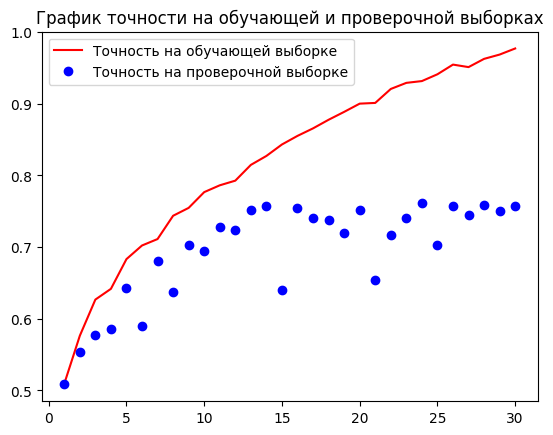

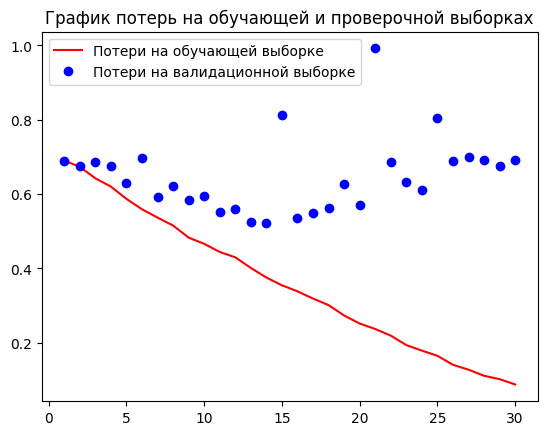

In [26]:
import matplotlib.pyplot as plt           # библиотека для рисования графиков
acc = history.history['acc']              # данные о точности на обучающей выборке
val_acc = history.history['val_acc']      # данные о точности на проверочной выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']    # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()                                                                 #  рисуем график

Аугментация

In [27]:
datagen = ImageDataGenerator(
 rotation_range=40,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest')

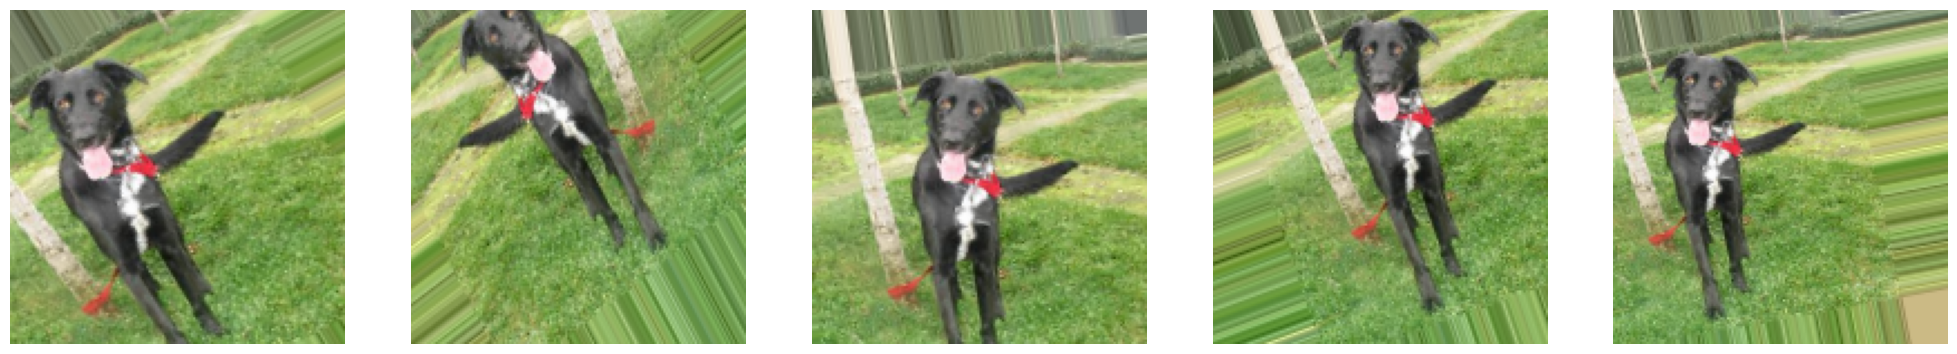

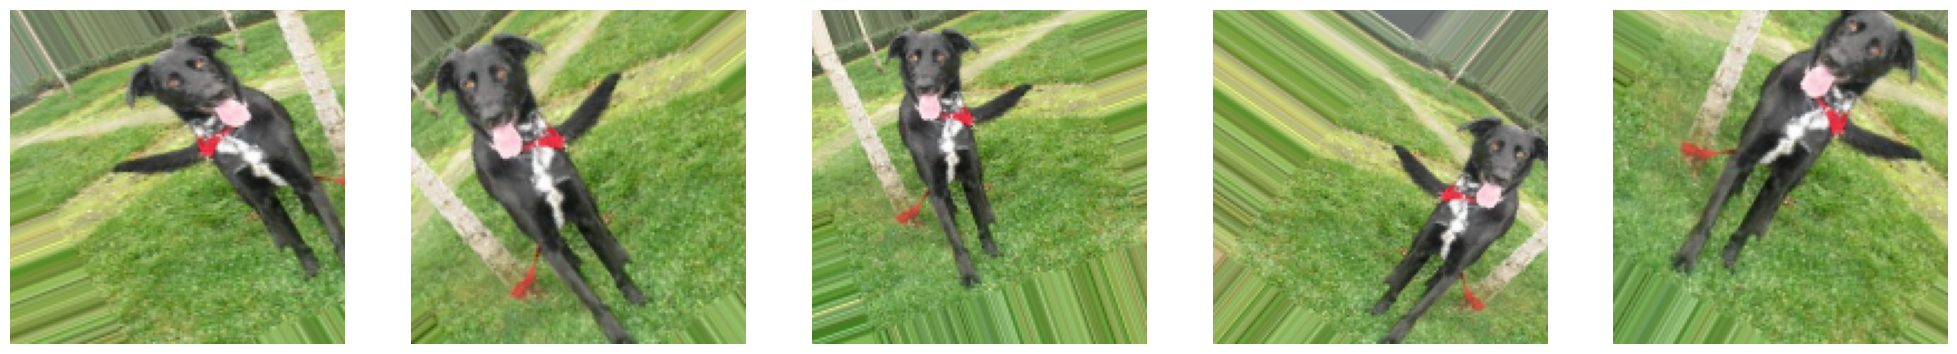

In [28]:
from keras.preprocessing import image # для работы с изображениями

img = validation_generator[0][0][7]   # выводим случайную картинку с помощью генератора (первый индекс - картинка или метка, второй - номер пакета, третий - номер изображения в пакете)
x = image.img_to_array(img)           # преобразования изображений в матрицу NumPy
x = x.reshape((1,) + x.shape)         # изменяем форму картинки, так как flow работет с массивами изображений, то указываем, что картинка будет одна
columns = 5                           # в сколько колонок выводить данные

i = 0
for batch in datagen.flow(x, batch_size=1):  # запускаем генерацию их массива изображений, пока не встретиться в цикле break
    ix = i % columns # Отображаем по 5 (или другое число, заданное columns) в строку
    # Остаток от деления на 5 равный нулю говорит, что пора перейти на следующую строку (новый график)
    if ix == 0:
        fig, ax = plt.subplots(1, columns, figsize=(25, 8)) # Область построения графика: одна строка в 5 колонок

    ax[ix].imshow(image.array_to_img(batch[0])) # Отображаем изображение животного на графике
    ax[ix].axis('off') # Отключаем отображение осей на графике

    i += 1
    if i % 10 == 0: # если сгенерировали 10 картинок, то можно прервать генерацию
        break
plt.show()

In [29]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [30]:
BATCH_SIZE = 24

# генератор для обучающей выборки
train_datagen = ImageDataGenerator(
    rescale=1./255,           # нормализация данных
    rotation_range=40,        # поворот 40 градусов
    width_shift_range=0.2,    # смещенние изображения по горизонтали
    height_shift_range=0.2,   # смещенние изображения по вертикали
    shear_range=0.2,          # случайный сдвиг
    zoom_range=0.2,           # случайное масштабирование
    horizontal_flip=True,     # отражение по горизонтали
)

# генератор для проверочной выборки
test_datagen = ImageDataGenerator(rescale=1./255)

# генерация картинок из папки для обучающей выборки
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# генерация картинок из папки для проверочной выборки
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
# обучаем модель
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator # число шагов вычисляем как число образцов на размер пакета
)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 242ms/step - acc: 0.4791 - loss: 0.6998 - val_acc: 0.4980 - val_loss: 0.6910
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 181ms/step - acc: 0.5322 - loss: 0.6891 - val_acc: 0.5120 - val_loss: 0.6942
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - acc: 0.5077 - loss: 0.6916 - val_acc: 0.5000 - val_loss: 0.7310
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - acc: 0.5639 - loss: 0.6780 - val_acc: 0.5220 - val_loss: 0.7057
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - acc: 0.5900 - loss: 0.6711 - val_acc: 0.5680 - val_loss: 0.6789
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - acc: 0.6069 - loss: 0.6579 - val_acc: 0.5240 - val_loss: 0.7125
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - acc: 0.6107 - loss: 0.6597 - val_acc: 0.5220 - val_loss: 0.7195
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - acc: 0.6038 - loss: 0.6558 - val_acc: 0.5220 - val_loss: 0.7775
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1

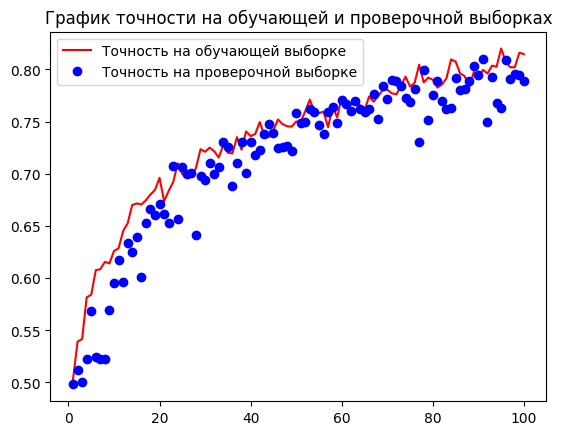

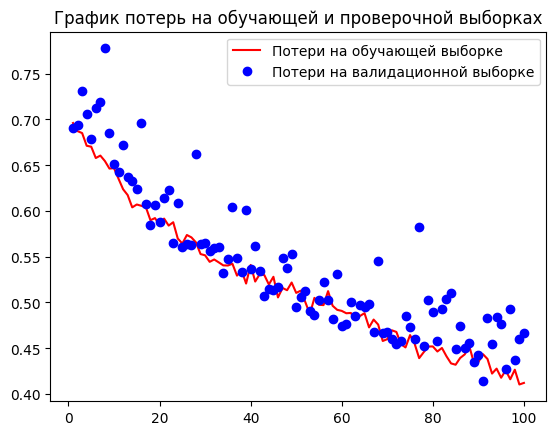

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')
plt.title('График точности на обучающей и проверочной выборках')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')
plt.title('График потерь на обучающей и проверочной выборках')
plt.legend()
plt.show()

In [33]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
from keras.applications import MobileNet
from keras import models
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import optimizers

def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

In [35]:
conv_base.trainable = True # В начале все слои обучаемые
set_trainable = False      # Переменная обучения изначально False
for layer in conv_base.layers: # Перебираем слои предобученной модели
    if layer.name == 'block5_conv1':
        set_trainable = True # Обучаем слои, начиная с block5_conv1
    if set_trainable:
        layer.trainable = True # Обучаем слоем
    else:
        layer.trainable = False # Замораживаем слой

In [36]:
# После заморозки и разморозки слоев модель необходимо скомпилировать, чтобы изменения применились

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)

# Обучаем модель
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator
)

model.save('cats_and_dogs_small_2.h5')

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - acc: 0.8219 - loss: 0.3725 - val_acc: 0.8020 - val_loss: 0.4338
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - acc: 0.8250 - loss: 0.3793 - val_acc: 0.8020 - val_loss: 0.4377
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - acc: 0.8501 - loss: 0.3637 - val_acc: 0.8000 - val_loss: 0.4428
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - acc: 0.8227 - loss: 0.3964 - val_acc: 0.8110 - val_loss: 0.4245
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - acc: 0.8456 - loss: 0.3594 - val_acc: 0.8110 - val_loss: 0.4257
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - acc: 0.8227 - loss: 0.3872 - val_acc: 0.8100 - val_loss: 0.4287
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 177ms/step - acc: 0.8386 - loss: 0.3658 - val_acc: 0.8110 - val_loss: 0.4268
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - acc: 0.8306 - loss: 0.3638 - val_acc: 0.8010 - val_loss: 0.4346
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1

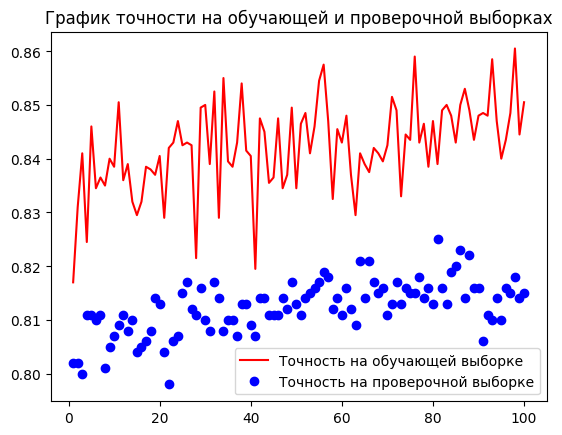

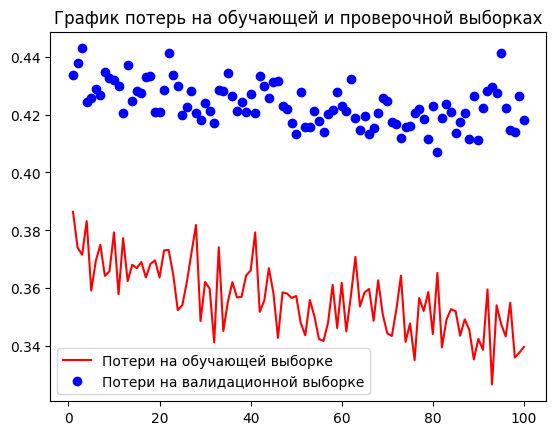

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')
plt.title('График точности на обучающей и проверочной выборках')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')
plt.title('График потерь на обучающей и проверочной выборках')
plt.legend()
plt.show()

In [42]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout

# Параметры
IMG_WIDTH = 100
IMG_HEIGHT = 100
BATCH_SIZE = 20
NUM_CLASSES = 1  # Для бинарной классификации

# Генератор изображений
datagen = ImageDataGenerator(rescale=1./255)

# Функция извлечения признаков
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, IMG_WIDTH, IMG_HEIGHT, 3))  # Используем форму для изображений
    labels = np.zeros(shape=(sample_count))

    generator = datagen.flow_from_directory(
        directory,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = inputs_batch  # Сохраняем изображения
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1

        if i * BATCH_SIZE >= sample_count:
            break

    return features, labels

# Извлекаем признаки для обучающей, проверочной и тестовой выборок
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# Создаем пользовательскую модель
input_tensor = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor)

# Добавляем свои слои
custom_model = GlobalAveragePooling2D()(base_model.output)
custom_model = Dense(64, activation='relu')(custom_model)
custom_model = Dropout(0.5)(custom_model)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(custom_model)  # Используем sigmoid для бинарной классификации

# Компилируем модель
model = models.Model(inputs=input_tensor, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Обучаем модель на изображениях
history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_data=(validation_features, validation_labels)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 70ms/step - accuracy: 0.5815 - loss: 0.7339 - val_accuracy: 0.8360 - val_loss: 0.3470
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7358 - loss: 0.4945 - val_accuracy: 0.8770 - val_loss: 0.2758
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8440 - loss: 0.3457 - val_accuracy: 0.8840 - val_loss: 0.2630
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8809 - loss: 0.2976 - val_accuracy: 0.8920 - val_loss: 0.2586
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8971 - loss: 0.2392 - val_accuracy: 0.9030 - val_loss: 0.2561
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9082 - loss: 0.2204 - val_accuracy: 0.9040 - val_loss: 0.2539
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9298 - loss: 0.1777 - val_accura

In [43]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('Точность на контрольной выборке:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9588 - loss: 0.1155
Точность на контрольной выборке: 0.9570000171661377
